In [1]:
import os
import shutil
from tempfile import mkdtemp
from PIL import Image
import pytesseract
from transformers import BlipProcessor, BlipForConditionalGeneration, MarianMTModel, MarianTokenizer
from IPython.display import display, Image as IPImage

In [6]:
# Указать путь к Tesseract
pytesseract.pytesseract.tesseract_cmd = r"/usr/bin/tesseract"

# Настройка BLIP для генерации описаний
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Настройка модели перевода (с английского на русский)
translation_model_name = "Helsinki-NLP/opus-mt-en-ru"
translator_model = MarianMTModel.from_pretrained(translation_model_name)
translator_tokenizer = MarianTokenizer.from_pretrained(translation_model_name)

# Папка для сохранения результатов
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

def translate_to_russian(text):
    """Перевод текста с английского на русский."""
    inputs = translator_tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    translated = translator_model.generate(**inputs)
    translated_text = translator_tokenizer.decode(translated[0], skip_special_tokens=True)
    return translated_text

def process_image(image_path):
    """Обработка одного изображения: извлечение текста и генерация описания."""
    try:
        # Открыть изображение
        image = Image.open(image_path)
        display(IPImage(image_path))

        # 1. Извлечь текст с изображения (OCR) на русском языке
        extracted_text = pytesseract.image_to_string(image, lang="rus+eng").strip()

        # 2. Сгенерировать описание изображения (VLM)
        inputs = blip_processor(image, return_tensors="pt")
        outputs = blip_model.generate(**inputs)
        english_description = blip_processor.decode(outputs[0], skip_special_tokens=True)

        # 3. Перевести описание на русский
        russian_description = translate_to_russian(english_description)

        return extracted_text, english_description, russian_description
    except Exception as e:
        print(f"Ошибка обработки {image_path}: {e}")
        return None, None, None

def save_results(file_name, extracted_text, english_description, russian_description):
    """Сохранение результатов обработки в текстовый файл."""
    result_file_path = os.path.join(RESULTS_DIR, f"{file_name}.txt")
    try:
        with open(result_file_path, "w", encoding="utf-8") as f:
            f.write("=== Результаты обработки ===\n")
            f.write(f"Текст (OCR):\n{extracted_text}\n\n")
            f.write(f"Описание (на английском):\n{english_description}\n\n")
            f.write(f"Описание (на русском):\n{russian_description}\n")
        print(f"Результаты сохранены в файл: {result_file_path}")
    except Exception as e:
        print(f"Ошибка сохранения результатов: {e}")

def main(uploaded_image_path):
    """Главная функция для обработки изображения."""
    # Проверка существования файла
    if not os.path.exists(uploaded_image_path):
        print(f"Файл {uploaded_image_path} не найден!")
        return

    # Создать временную папку
    temp_dir = mkdtemp()
    print(f"Временная папка создана: {temp_dir}")

    try:
        # Сохранить загруженное изображение во временную папку
        temp_image_path = os.path.join(temp_dir, os.path.basename(uploaded_image_path))
        shutil.copy(uploaded_image_path, temp_image_path)

        print(f"Изображение скопировано во временную папку: {temp_image_path}")

        # Обработать изображение
        extracted_text, english_description, russian_description = process_image(temp_image_path)

        if extracted_text is None and english_description is None:
            print(f"Ошибка обработки изображения: {uploaded_image_path}")
            return

        # Сохранить результаты в текстовый файл
        file_name = os.path.splitext(os.path.basename(uploaded_image_path))[0]
        save_results(file_name, extracted_text, english_description, russian_description)

        # Вывод результатов
        print("\n=== Результаты обработки ===")
        print(f"Текст (OCR):\n{extracted_text}")
        print(f"Описание (на английском):\n{english_description}")
        print(f"Описание (на русском):\n{russian_description}")
        print("============================")

    finally:
        # Удалить временную папку и все её содержимое
        shutil.rmtree(temp_dir)
        print(f"Временная папка удалена: {temp_dir}")

Временная папка создана: /tmp/tmpdgulmuh9
Изображение скопировано во временную папку: /tmp/tmpdgulmuh9/Парус.png


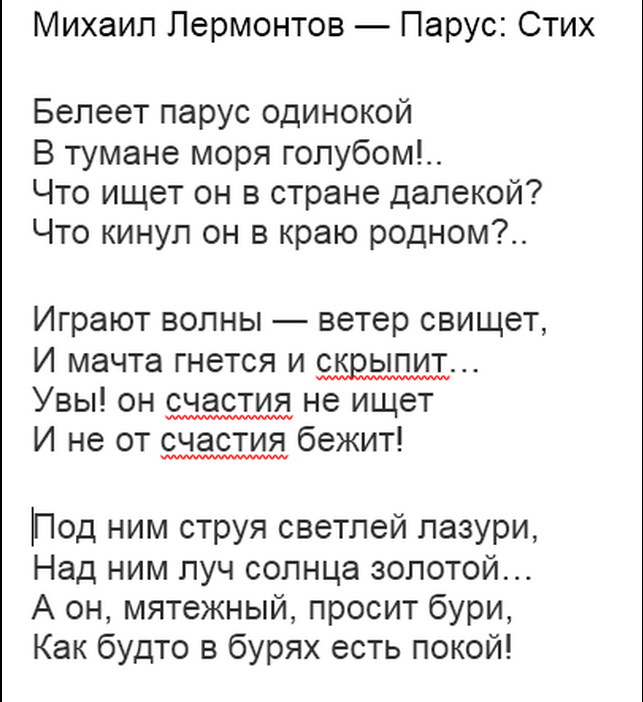

Результаты сохранены в файл: results/Парус.txt

=== Результаты обработки ===
Текст (OCR):
Михаил Лермонтов — Парус: Стих

Белеет парус одинокой

В тумане моря голубом'..

Что ищет он в стране далекой?
Что кинул он в краю родном?..

Играют волны — ветер свищет,
И мачта гнется и скрыпит...
Увы! он счастия не ищет

И не от счастия бежит!

Под ним струя светлей лазури,
Над ним луч солнца золотой...
А он, мятежный, просит бури,
Как будто в бурях есть покой!
Описание (на английском):
the text in the russian language is a red circle
Описание (на русском):
текст на русском языке - красный круг.
Временная папка удалена: /tmp/tmpdgulmuh9


In [9]:
# Пример работы
# Путь к загруженному изображению (замените на реальный путь)
uploaded_image_path = "/home/akayo/Загрузки/Парус.png"  # Укажите путь к файлу

# Вызов главной функции
main(uploaded_image_path)